# Latent Semantic Indexing (LSI) 구현

## 개요
LSI(Latent Semantic Indexing)는 문서 집합에서 단어와 문서 간의 잠재적인 의미 관계를 파악하는 비지도 학습 기법입니다. SVD(Singular Value Decomposition)를 활용하여 고차원의 문서-단어 행렬을 저차원의 의미 공간으로 축소시키는 것이 핵심입니다.

## 데이터셋: BBC News
- 5개 카테고리의 뉴스 기사 (business, entertainment, politics, sport, tech)
- 약 2,225개의 문서
- 각 문서는 전문 기자가 작성한 영문 뉴스 기사

## LSI 작동 원리

### 1. 문서-단어 행렬 생성
- TF-IDF(Term Frequency-Inverse Document Frequency) 행렬 생성
- 행: 문서, 열: 단어
- 각 셀: 해당 단어가 문서에서 가지는 중요도

### 2. SVD 분해
문서-단어 행렬 A를 세 개의 행렬로 분해:
```
A = U × Σ × V^T
```
- U: 문서-개념 행렬 (left singular vectors)
- Σ: 특이값 대각 행렬 (singular values)
- V^T: 단어-개념 행렬 (right singular vectors)

### 3. 차원 축소
- 상위 k개의 특이값만 선택
- 의미 공간의 차원을 축소하여 노이즈 제거
- k는 일반적으로 100-300 사이의 값 사용

### 4. 잠재 의미 공간
축소된 행렬에서:
- 문서들은 U × Σ로 표현
- 단어들은 V로 표현
- 유사한 의미를 가진 문서/단어들은 이 공간에서 가까이 위치

## LSI의 장점
1. 동의어(Synonymy) 문제 해결
   - 같은 의미를 가진 다른 단어들을 하나의 개념으로 통합
2. 다의어(Polysemy) 문제 부분 해결
   - 문맥에 따른 단어의 의미 구분
3. 노이즈 제거
   - 중요하지 않은 패턴들을 제거하여 핵심 의미 구조 파악

## LSI의 한계
1. 계산 복잡도
   - 대규모 행렬의 SVD 계산이 필요
2. 새로운 문서 추가의 어려움
   - 전체 모델을 다시 계산해야 함
3. 음수 값의 해석
   - SVD 결과로 나오는 음수 값의 의미 해석이 어려움


### LSI(Latent Semantic Indexing) 활용 방안
1. 텍스트 분석
- 문서 유사도 분석 (코사인 유사도)
- 문서 군집화 및 자동 분류
- 유사 문서 자동 추천

2. 정보 검색
- 의미 기반 검색 시스템 구현
- 연관 검색어 추천
콘텐츠 기반 추천 시스템

3. 트렌드 분석
- 토픽 중요도 시계열 분석
- 새로운 토픽 발견
- 토픽 트렌드 시각화

4. 비즈니스 응용
- 고객 피드백 및 시장 트렌드 분석
- 뉴스 기사 분류 및 추천
- 연구/학술 트렌드 분석
- 고객 문의 자동 분류

In [1]:
# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
from zipfile import ZipFile
from io import BytesIO

# NLTK 데이터 다운로드
nltk.download('punkt')
nltk.download('stopwords')

# BBC News 데이터셋 다운로드 함수
def download_bbc_dataset():
    # 데이터셋 URL
    url = "http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip"
    
    # 데이터를 저장할 디렉토리 생성
    if not os.path.exists('bbc'):
        print("Downloading BBC dataset...")
        response = requests.get(url)
        with ZipFile(BytesIO(response.content)) as zip_file:
            zip_file.extractall()
        print("Download completed!")
    else:
        print("Dataset already exists!")

# 데이터 로드 함수
def load_bbc_data():
    categories = ['business', 'entertainment', 'politics', 'sport', 'tech']
    texts = []
    labels = []
    
    for category in categories:
        path = f'bbc/{category}'
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                labels.append(category)
    
    return pd.DataFrame({'text': texts, 'category': labels})

# 데이터셋 다운로드 및 로드
download_bbc_dataset()
df = load_bbc_data()

# 기본 데이터 정보 출력
print("\nDataset Info:")
print(f"Total number of documents: {len(df)}")
print("\nDocuments per category:")
print(df['category'].value_counts())

# 첫 번째 문서 일부 출력
print("\nFirst document preview:")
print(df['text'].iloc[0][:500])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Download completed!

Dataset Info:
Total number of documents: 2225

Documents per category:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

First document preview:
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time W


# 전처리

In [5]:
# NLTK 데이터 다운로드
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dongi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def basic_preprocess(text):
    """
    기본적인 텍스트 전처리를 수행하는 함수
    - 소문자 변환
    - 단순 공백 기준 토큰화
    - 불용어 제거
    - 알파벳만 포함된 단어 선택
    """
    # 소문자 변환
    text = text.lower()
    
    # 단순 토큰화
    tokens = text.split()
    
    # 불용어 로드
    stop_words = set(stopwords.words('english'))
    
    # 불용어 제거 및 알파벳으로만 이루어진 단어 선택
    tokens = [token for token in tokens 
             if token not in stop_words
             and token.isalpha()]
    
    return tokens

In [9]:
# 첫 번째 문서에 대해 테스트
sample_text = df['text'].iloc[0]
processed_tokens = basic_preprocess(sample_text)

# 결과 확인
print("원본 텍스트 일부:")
print(sample_text[:200])
print("\n처리된 토큰 일부:")
print(processed_tokens[:20])
print(f"\n토큰 수: {len(processed_tokens)}")

# 단어 빈도 확인
from collections import Counter
word_freq = Counter(processed_tokens)

# 가장 흔한 단어 10개 출력
print("\n가장 흔한 단어:")
for word, count in word_freq.most_common(10):
    print(f"{word}: {count}")

원본 텍스트 일부:
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one o

처리된 토큰 일부:
['ad', 'sales', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profits', 'us', 'media', 'giant', 'timewarner', 'jumped', 'three', 'months', 'one', 'biggest', 'investors', 'benefited', 'sales']

토큰 수: 189

가장 흔한 단어:
timewarner: 7
profit: 5
profits: 5
internet: 4
said: 4
sales: 3
time: 3
warner: 3
us: 3
fourth: 3


In [12]:
# 모든 문서에 전처리 적용
print("전체 문서 전처리 중...")
df['processed_tokens'] = df['text'].apply(basic_preprocess)

# 문서별 단어 수 계산
df['token_count'] = df['processed_tokens'].apply(len)

# 기본 통계 확인
print("\n문서 길이 통계:")
print(df['token_count'].describe())


전체 문서 전처리 중...

문서 길이 통계:
count    2225.000000
mean      172.863820
std        99.821729
min        37.000000
25%       112.000000
50%       152.000000
75%       212.000000
max      1749.000000
Name: token_count, dtype: float64


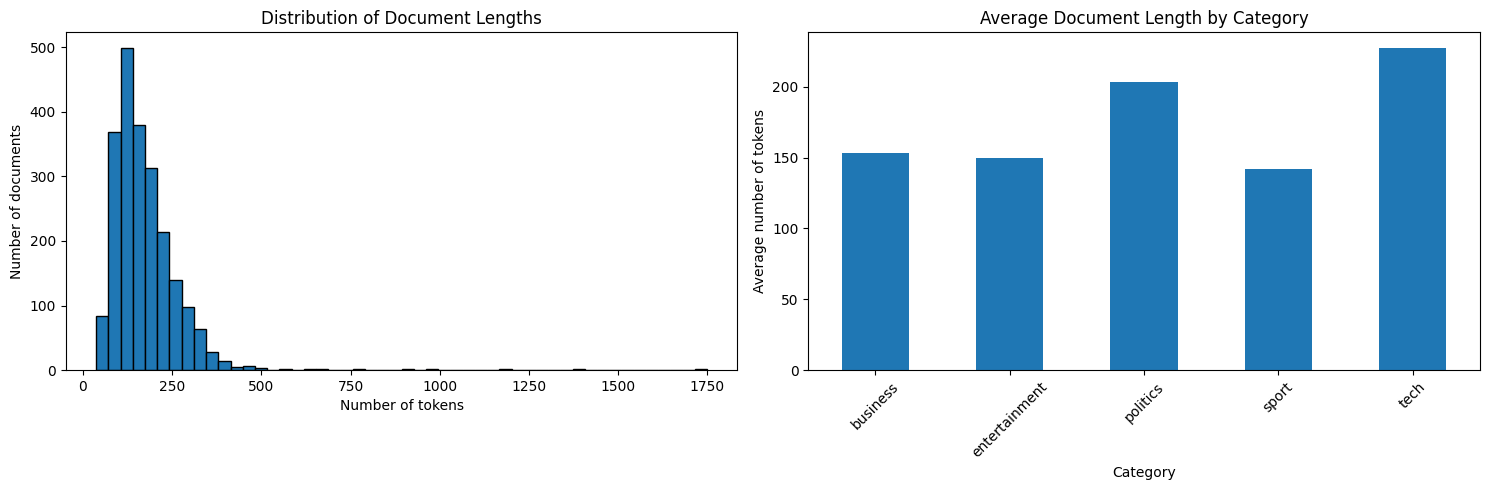


전체 데이터셋에서 가장 흔한 단어 20개:
said: 4908
mr: 2979
would: 2558
also: 2141
new: 1929
people: 1754
us: 1614
one: 1592
could: 1499
last: 1369
first: 1253
two: 1135
make: 904
told: 898
best: 892
government: 878
get: 875
time: 828
year: 812
made: 812


In [13]:
# 시각화
plt.figure(figsize=(15, 5))

# 1. 문서 길이 분포
plt.subplot(1, 2, 1)
plt.hist(df['token_count'], bins=50, edgecolor='black')
plt.title('Distribution of Document Lengths')
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')

# 2. 카테고리별 평균 문서 길이
plt.subplot(1, 2, 2)
df.groupby('category')['token_count'].mean().plot(kind='bar')
plt.title('Average Document Length by Category')
plt.xlabel('Category')
plt.ylabel('Average number of tokens')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 전체 데이터셋에서 가장 흔한 단어 확인
all_words = [word for tokens in df['processed_tokens'] for word in tokens]
word_freq_all = Counter(all_words)

print("\n전체 데이터셋에서 가장 흔한 단어 20개:")
for word, count in word_freq_all.most_common(20):
    print(f"{word}: {count}")

In [14]:
def improved_preprocess(text):
    """
    개선된 텍스트 전처리 함수
    - 추가 불용어 제거
    - 최소 단어 길이 제한
    """
    # 소문자 변환
    text = text.lower()
    
    # 토큰화
    tokens = text.split()
    
    # 기본 불용어 + 추가 불용어
    stop_words = set(stopwords.words('english'))
    additional_stops = {'said', 'mr', 'would', 'also', 'could', 'one', 'two', 
                       'last', 'first', 'make', 'made', 'told', 'get'}
    stop_words.update(additional_stops)
    
    # 불용어 제거, 알파벳만 포함된 단어 선택, 길이 3 이상인 단어만 선택
    tokens = [token for token in tokens 
             if token not in stop_words
             and token.isalpha()
             and len(token) >= 3]
    
    return tokens

# 개선된 전처리 적용
print("전체 문서 전처리 중...")
df['processed_tokens'] = df['text'].apply(improved_preprocess)

# 결과 확인
all_words = [word for tokens in df['processed_tokens'] for word in tokens]
word_freq_all = Counter(all_words)

print("\n개선된 전처리 후 가장 흔한 단어 20개:")
for word, count in word_freq_all.most_common(20):
    print(f"{word}: {count}")

전체 문서 전처리 중...

개선된 전처리 후 가장 흔한 단어 20개:
new: 1929
people: 1754
best: 892
government: 878
time: 828
year: 812
like: 808
many: 803
world: 792
next: 754
number: 736
three: 731
take: 719
back: 695
film: 687
music: 677
bbc: 672
set: 651
way: 626
game: 620


# TF-IDF 행렬 생성

Term Frequency (TF)
- 특정 단어가 문서 내에서 등장하는 빈도
- 문서 내에서 자주 등장하는 단어일수록 중요하다고 가정

Inverse Document Frequency (IDF)
- 전체 문서 집합에서 특정 단어의 희소성을 나타냄
- 많은 문서에서 공통적으로 등장하는 단어의 중요도를 감소
- $IDF(t) = log(전체 문서 수 / 단어 t가 등장한 문서 수)$

In [15]:
# 전처리된 토큰들을 다시 텍스트로 변환
df['processed_text'] = df['processed_tokens'].apply(' '.join)

# TF-IDF 벡터화
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=5000,  # 상위 5000개 단어만 사용
    min_df=5,          # 최소 5개 문서에서 등장해야 함
    max_df=0.95        # 전체 문서의 95% 이상에서 등장하는 단어는 제외
)

# TF-IDF 행렬 생성
tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

# 기본 정보 출력
print("TF-IDF 행렬 크기:", tfidf_matrix.shape)
print("단어 집합 크기:", len(vectorizer.get_feature_names_out()))

# 상위 특성(단어) 확인
feature_names = vectorizer.get_feature_names_out()
print("\n상위 20개 특성(단어):")
for name in feature_names[:20]:
    print(name)

# 희소성 확인
sparsity = (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100
print(f"\n행렬 희소성: {sparsity:.2f}%")

TF-IDF 행렬 크기: (2225, 5000)
단어 집합 크기: 5000

상위 20개 특성(단어):
aaas
abandoned
abc
ability
able
abn
abortion
abroad
absence
absolute
absolutely
abuse
abused
academy
accept
acceptable
accepted
accepting
access
accessible

행렬 희소성: 2.00%


In [20]:
# TF-IDF 행렬을 데이터프레임으로 변환
feature_names = vectorizer.get_feature_names_out()
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(dense_matrix, columns=feature_names)

# 기본 정보 출력
print("TF-IDF 데이터프레임 shape:", tfidf_df.shape)

# 첫 5개 문서, 첫 10개 단어에 대한 TF-IDF 값 확인
print("\n첫 5개 문서의 TF-IDF 값 (처음 10개 단어):")
print(tfidf_df.iloc[:5, :10])

# 0이 아닌 값들의 분포 확인
non_zero_values = tfidf_matrix.data
print("\nTF-IDF 값 통계:")
print(pd.Series(non_zero_values).describe())

# 특정 문서에서 가장 높은 TF-IDF 값을 가진 단어들 확인 (예: 첫 번째 문서)
doc_idx = 0
top_terms = tfidf_df.iloc[doc_idx].nlargest(10)
print(f"\n문서 {doc_idx}의 상위 10개 단어:")
print(top_terms)

TF-IDF 데이터프레임 shape: (2225, 5000)

첫 5개 문서의 TF-IDF 값 (처음 10개 단어):
   aaas  abandoned  abc  ability  able  abn  abortion  abroad  absence  \
0   0.0        0.0  0.0      0.0   0.0  0.0       0.0     0.0      0.0   
1   0.0        0.0  0.0      0.0   0.0  0.0       0.0     0.0      0.0   
2   0.0        0.0  0.0      0.0   0.0  0.0       0.0     0.0      0.0   
3   0.0        0.0  0.0      0.0   0.0  0.0       0.0     0.0      0.0   
4   0.0        0.0  0.0      0.0   0.0  0.0       0.0     0.0      0.0   

   absolute  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  

TF-IDF 값 통계:
count    222971.000000
mean          0.079556
std           0.060413
min           0.004293
25%           0.047033
50%           0.063791
75%           0.090188
max           0.856823
dtype: float64

문서 0의 상위 10개 단어:
profit         0.323824
profits        0.309733
aol            0.256815
warner         0.253717
internet       0.206842
subscribers    0.167222
quarter        0.166784
fourth

# SVD를 사용한 차원 축소
SVD(Singular Value Decomposition)는 LSI의 핵심 부분입니다. TF-IDF 행렬을 더 낮은 차원의 의미 공간으로 변환하는 역할을 합니다.

## 행렬 분해
- TF-IDF 행렬 A를 세 개의 행렬로 분해: A = U × Σ × V^T
- U: 문서-토픽 행렬 (left singular vectors)  => 문서들이 "잠재적 주제"와 얼마나 관련있는지
- Σ: 특이값을 대각선상에 가진 행렬 (singular values) => 각 "잠재적 주제"가 얼마나 중요한지
- V^T: 단어-토픽 행렬 (right singular vectors) => 단어들이 "잠재적 주제"와 얼마나 관련있는지

## 차원 축소
- 상위 k개의 특이값만 선택 (여기서는 k=100)
- 나머지 작은 특이값들은 노이즈로 간주하고 제거

## 결과 해석
- explained_variance_ratio_: 각 컴포넌트가 설명하는 분산의 비율
- cumulative_variance_ratio: 누적 설명된 분산 비율
- components_: 각 토픽을 구성하는 단어들의 가중치

In [25]:
# SVD를 사용한 차원 축소
from sklearn.decomposition import TruncatedSVD

# 20개의 토픽으로 축소
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)
lsi_matrix = svd.fit_transform(tfidf_matrix)

# 설명된 분산 비율 확인
explained_variance = svd.explained_variance_ratio_

# 누적 설명된 분산 비율
cumulative_variance_ratio = np.cumsum(explained_variance)

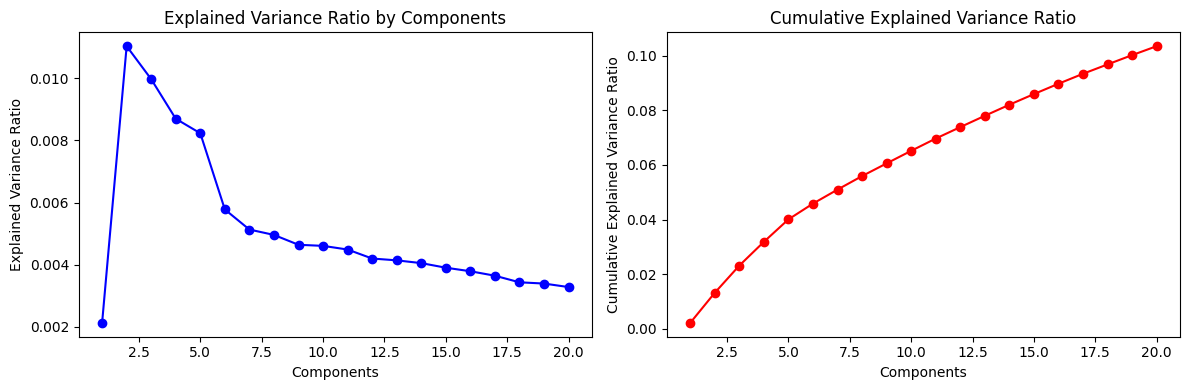


상위 10개 토픽의 주요 단어:
Topic 1: people, new, government, best, labour, film, music, world, blair, year
Topic 2: labour, blair, election, brown, government, party, tax, prime, tory, chancellor
Topic 3: mobile, music, digital, sales, phone, technology, market, users, broadband, growth
Topic 4: film, best, award, actor, awards, actress, oscar, films, director, music
Topic 5: growth, economy, economic, oil, bank, sales, best, film, prices, dollar
Topic 6: yukos, court, russian, company, oil, firm, legal, law, bankruptcy, shares
Topic 7: music, band, album, sales, top, olympic, champion, record, chart, indoor
Topic 8: olympic, champion, world, indoor, seed, race, athens, holmes, security, users
Topic 9: england, music, ireland, wales, band, robinson, yukos, nations, six, france
Topic 10: mobile, yukos, oil, russian, tax, phone, film, phones, brown, bankruptcy

각 토픽의 설명력 (상위 10개):
Topic 1: 0.21%
Topic 2: 1.10%
Topic 3: 1.00%
Topic 4: 0.87%
Topic 5: 0.82%
Topic 6: 0.58%
Topic 7: 0.51%
Topic 8: 0.

In [26]:
# 결과 시각화
plt.figure(figsize=(12, 4))

# 1. 설명된 분산 비율
plt.subplot(1, 2, 1)
plt.plot(range(1, n_components + 1), explained_variance, 'bo-')
plt.title('Explained Variance Ratio by Components')
plt.xlabel('Components')
plt.ylabel('Explained Variance Ratio')

# 2. 누적 설명된 분산 비율
plt.subplot(1, 2, 2)
plt.plot(range(1, n_components + 1), cumulative_variance_ratio, 'ro-')
plt.title('Cumulative Explained Variance Ratio')
plt.xlabel('Components')
plt.ylabel('Cumulative Explained Variance Ratio')

plt.tight_layout()
plt.show()

# 상위 10개 토픽의 주요 단어 출력
def print_topics(svd_model, feature_names, n_top_words=10):
    for i, comp in enumerate(svd_model.components_[:10]):  # 상위 10개 토픽만
        terms = [feature_names[idx] for idx in comp.argsort()[:-n_top_words-1:-1]]
        print(f'Topic {i + 1}: {", ".join(terms)}')

print("\n상위 10개 토픽의 주요 단어:")
print_topics(svd, feature_names)

# 추가로 각 토픽의 설명력 출력
print("\n각 토픽의 설명력 (상위 10개):")
for i, var in enumerate(explained_variance[:10]):
    print(f"Topic {i+1}: {var*100:.2f}%")

In [28]:
# 첫 번째 문서 내용 출력
print("첫 번째 문서 내용:")
print(df['text'].iloc[0][:500], "...\n")  # 처음 500자만 출력

# 문서의 카테고리 확인
print("문서 카테고리:", df['category'].iloc[0])

첫 번째 문서 내용:
Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.

Time W ...

문서 카테고리: business


# 문서-토픽 유사도 계산

In [29]:
# 문서-토픽 유사도 계산
def get_document_topics(doc_idx):
    doc_vector = lsi_matrix[doc_idx]
    
    # 토픽별 점수와 인덱스를 함께 저장
    topic_scores = [(i, score) for i, score in enumerate(doc_vector)]
    
    # 점수 기준으로 정렬
    topic_scores.sort(key=lambda x: abs(x[1]), reverse=True)
    
    return topic_scores

# 예시: 첫 번째 문서의 토픽 분포 확인
print("\n첫 번째 문서의 토픽 분포:")
doc_topics = get_document_topics(0)
for topic_idx, score in doc_topics[:5]:  # 상위 5개 토픽만
    print(f"Topic {topic_idx + 1}: {score:.4f}")
    # 해당 토픽의 주요 단어들 출력
    terms = [feature_names[idx] for idx in svd.components_[topic_idx].argsort()[:-5-1:-1]]
    print(f"주요 단어: {', '.join(terms)}\n")


첫 번째 문서의 토픽 분포:
Topic 1: 0.1916
주요 단어: people, new, government, best, labour

Topic 14: -0.1841
주요 단어: brown, yukos, chancellor, blair, economic

Topic 3: 0.1514
주요 단어: mobile, music, digital, sales, phone

Topic 5: 0.1349
주요 단어: growth, economy, economic, oil, bank

Topic 13: 0.1074
주요 단어: brown, blair, shares, prime, greek




문서 0의 토픽 분포:
카테고리: business
문서 미리보기: Ad sales boost Time Warner profit

Quarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.

The firm, which is now one o ...

Topic 1 (score: 0.1916)
주요 단어: people, new, government, best, labour

Topic 14 (score: -0.1841)
주요 단어: brown, yukos, chancellor, blair, economic

Topic 3 (score: 0.1514)
주요 단어: mobile, music, digital, sales, phone


문서 510의 토픽 분포:
카테고리: entertainment
문서 미리보기: Gallery unveils interactive tree

A Christmas tree that can receive text messages has been unveiled at London's Tate Britain art gallery.

The spruce has an antenna which can receive Bluetooth texts s ...

Topic 1 (score: 0.0757)
주요 단어: people, new, government, best, labour

Topic 20 (score: -0.0430)
주요 단어: music, digital, apple, deutsche, consumer

Topic 16 (score: -0.0371)
주요 단어: best, games, government, european, tax


문서 896의 토픽 분포:
카테고리: politics
문서 미리보기: Labour plans maternity pay rise

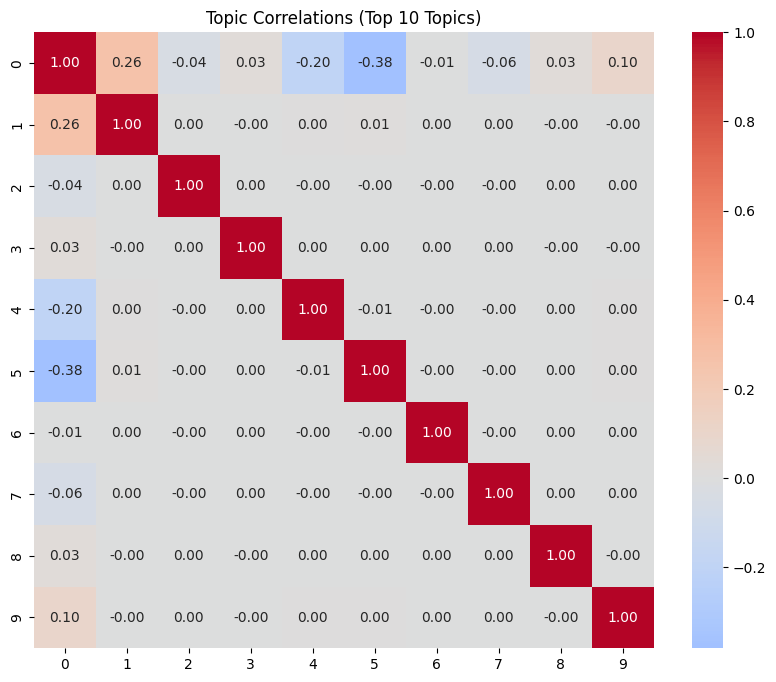

In [30]:
# 여러 문서의 토픽 분포 분석
def analyze_document_topics(doc_indices):
    for doc_idx in doc_indices:
        print(f"\n문서 {doc_idx}의 토픽 분포:")
        print(f"카테고리: {df['category'].iloc[doc_idx]}")
        print("문서 미리보기:", df['text'].iloc[doc_idx][:200], "...\n")
        
        doc_topics = get_document_topics(doc_idx)
        for topic_idx, score in doc_topics[:3]:  # 상위 3개 토픽만
            print(f"Topic {topic_idx + 1} (score: {score:.4f})")
            terms = [feature_names[idx] for idx in svd.components_[topic_idx].argsort()[:-5-1:-1]]
            print(f"주요 단어: {', '.join(terms)}\n")

# 각 카테고리에서 첫 번째 문서를 분석
category_first_docs = []
for category in df['category'].unique():
    doc_idx = df[df['category'] == category].index[0]
    category_first_docs.append(doc_idx)

analyze_document_topics(category_first_docs)

# 토픽 간의 관계 분석
topic_correlations = np.corrcoef(lsi_matrix.T)

# 상위 토픽들 간의 상관관계 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(topic_correlations[:10, :10], 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            fmt='.2f')
plt.title('Topic Correlations (Top 10 Topics)')
plt.show()